In [ ]:
###########################################
# This file contains the following:
# 1. Linear Transformer Model
# 2. Function for clipping gradient
# 3. Function for generating random data
###########################################


import torch
from torch import nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definition of a single linear attention unit for linear-regression data
# P is the value matrix
# Q is the product of key,query matrices
# the dimensions of the input are
# B: batch-size of prompts
# N: context length (excluding query)
# d: covariate dimension
# P,Q are d x d matrices
# Z is a B x (N+1) + (d+1) matrix
# Output is also B x (N+1) + (d+1)

# For linear attention, activation = None
# For standard attention, activation(x) = torch.nn.functional.softmax(x, dim = 2)
# For ReLU attention, activation(x) = torch.nn.relu(x)
def attention(P,Q,Z, activation = None):
    B= Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    P_full =  torch.cat([P,torch.zeros(1,d).to(device)],dim=0)
    P_full =  torch.cat([P_full,torch.zeros(d+1,1).to(device)],dim=1)
    P_full[d,d] = 1
    Q_full = torch.cat([Q, torch.zeros(1,d).to(device)],dim=0)
    Q_full = torch.cat([Q_full, torch.zeros(d+1,1).to(device)],dim=1)
    A = torch.eye(N+1).to(device)
    A[N,N] = 0
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z,Q_full,Z))
    if activation is not None:
        Attn = activation(Attn)
    key = torch.einsum('ij, BNj -> BNi', (P_full,Z))
    Output = torch.einsum('BNM,ML, BLi -> BNi', (Attn,A,key))
    return Output /N


# The Linear Transformer module
# n_layer denotes the number of layers
# n_head denotes the number of heads. In most of our experiments, n_head = 1
# d denotes the dimension of covariates
# var denotes the variance of initialization. It needs to be sufficiently small, but exact value is not important
# allparam: contains all the parameters, has dimension n_layer x n_head x 2 x d x d
# For example
# - P matrix at layer i, head j is allparam[i,j,0,:,:]
# - Q matrix at layer i, head j is allparam[i,j,1,:,:]
# If run_mode = 0 then training. If run_mode = 1 then in-context learning.
# The Linear Transformer module
class Transformer_F(nn.Module):
    def __init__(self, n_layer, n_head, N, d, var, run_mode):
        super(Transformer_F, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))

        # Z has shape (B, N+1, d+1), so alpha and gamma should have the same shape
        self.alpha = nn.Parameter(torch.zeros(n_layer, 1, N+1, d+1), requires_grad=(run_mode == 1))
        self.gamma = nn.Parameter(torch.zeros(n_layer, 1, N+1, d+1), requires_grad=(run_mode == 1))

        with torch.no_grad():
            self.allparam.normal_(0, var)

        self.n_layer = n_layer
        self.n_head = n_head
        self.run_mode = run_mode

    def forward(self, Z):
        B, N, d = Z.shape[0], Z.shape[1]-1, Z.shape[2]-1

        # Create a list for R, where each element corresponds to the dynamic memory for each layer
        R = [torch.zeros_like(Z) for _ in range(self.n_layer)]

        # Enforce the sparsity condition before processing
        self.zero_p()

        for i in range(self.n_layer):

            Zi = Z
            attention_sum = torch.zeros_like(Z)

            alpha_i = self.alpha[i, :, :, :]
            gamma_i = self.gamma[i, :, :, :]
            # The forward map of each layer is given by F(Z) = Z + attention(Z)
            for j in range(self.n_head):
                Pij = self.allparam[i, j, 0, :, :]
                Qij = self.allparam[i, j, 1, :, :]
                attention_sum += attention(Pij, Qij, Zi)

            # Update rule for training mode
            if self.run_mode == 0:
                R[i] = attention_sum
                Z = Zi + R[i]
            # Update rule for in-context learning
            else:
                R[i] = attention_sum
                Z = Zi + R[i] + sum(R[k] * self.alpha[k, :, :, :].expand(B, N+1, d+1) for k in range(i))

        return Z

    #enforces top-left-dxd-block sparsity on p
    def zero_p(self):
        for i in range(self.n_layer):
            for j in range(self.n_head):
                with torch.no_grad():
                    self.allparam[i,j,0,:,:].zero_()

    def identity_q(self):
        with torch.no_grad():  # Disable gradient tracking
            for i in range(self.n_layer):
                for j in range(self.n_head):
                    Qij = self.allparam[i,j,1,:,:]

                    # Zero out all off-diagonal elements
                    off_diag_mask = ~torch.eye(Qij.size(-1), dtype=torch.bool, device=Qij.device)
                    Qij.masked_fill_(off_diag_mask, 0)

                    # Set diagonal elements to the average of the original diagonal elements
                    diag_elements = Qij.diag()
                    diag_mean = diag_elements.mean()
                    Qij.fill_diagonal_(diag_mean)

                    # Safely copy the modified tensor back to allparam
                    self.allparam[i,j,1,:,:].copy_(Qij)

# evaluate the loss of model, given data (Z,y)
def in_context_loss(model, Z, y):
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    output = model(Z)
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean()
    return loss

# generate random data for linear regression
# mode: distribution of samples to generate. Currently supports 'normal', 'gamma', 'sphere'
# N: number of context examples
# d: dimension of covariates
# For gamma distribution:
# - shape_k: shape parameter of gamma distribution (unused otherwise)
# - scale parameter: hard coded so that when shape_k = 5/2 and d=5, the generated data is standard normal
def generate_data(mode='normal',N=20,d=1,B=1000,shape_k=0.1, U=None, D=None):
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B,1,d).normal_(0, 1).to(device)

    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W= torch.FloatTensor(B, d).normal_(0,1).to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())

    if mode =='sphere':
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
    elif mode == 'gamma':
        # random gamma scaling for X
        gamma_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,N])
        gamma_scales = torch.Tensor(gamma_scales).to(device)
        gamma_scales = gamma_scales.sqrt()
        # random gamma scaling for X_test
        gamma_test_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,1])
        gamma_test_scales = torch.Tensor(gamma_test_scales).to(device)
        gamma_test_scales = gamma_test_scales.sqrt()
        # normalize to unit norm
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
        # scale by gamma
        X.mul_(gamma_scales[:,:,None])
        X_test.mul_(gamma_test_scales[:,:,None])
    elif mode =='normal':
        assert True
    elif mode == 'relu':
        return generate_data_relu(N=N, d=d, B=B, hidden_dim=d)
    elif mode == 'mlp':
        generate_data_mlp(N=N, d=d, B=B, hidden_dim=d)
    else:
        assert False

    if U is not None:
        X = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))
        X_test = torch.einsum('ij, jk, BNk -> BNi', (U,D,X_test))

    y = torch.einsum('bi,bni->bn', (W, X)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test)).squeeze(1)
    X_comb= torch.cat([X,X_test],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)
    return Z.to(device),y_test.to(device)

def generate_data_inplace(Z, U=None, D=None):


    B = Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    X = Z[:,:,0:-1]
    X.normal_(0, 1).to(device)
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())
        Z[:,:,0:-1] = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))

    Z[:,:,-1] = torch.einsum('bi,bni->bn', (W, Z[:,:,0:-1])) #y update
    y_test = Z[:,-1,-1].detach().clone()
    Z[:,-1,-1].zero_()
    return Z.to(device),y_test.to(device)

def generate_data_sine(N=10, B=1000):
    # Sample amplitude a and phase p for each task
    a = torch.FloatTensor(B).uniform_(0.1, 5).to(device)
    p = torch.FloatTensor(B).uniform_(0, math.pi).to(device)

    X = torch.FloatTensor(B, N).uniform_(-5, 5).to(device)

    Y = a.unsqueeze(1) * torch.sin(p.unsqueeze(1) + X)

    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)

    return X, Y

def generate_data_relu(mode='normal', N=20, d=1, B=1000, shape_k=0.1, U=None, D=None, hidden_dim=100):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    # Define a 1-hidden layer ReLU network
    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    ).to(device)
    model[0].weight.data.normal_(0, 0.1)
    model[2].weight.data.normal_(0, 0.1)

    # Generate y values using the ReLU network
    y = model(X.view(-1, d)).view(B, N, 1)
    y_test = model(X_test.view(-1, d)).view(B, 1).squeeze(1)

    y_zero = torch.zeros(B, 1, 1).to(device)
    X_comb = torch.cat([X, X_test], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)

    return Z, y_test

def generate_data_mlp(N=20, d=1, B=1000, hidden_dim=100):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    # Define a 1-hidden layer ReLU network
    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, d)
    ).to(device)
    model[0].weight.data.normal_(0, 1)
    model[2].weight.data.normal_(0, 1)

    X_MLP = model(X.view(-1, d)).view(B, N, d)
    X_test_MLP = model(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0,1).to(device)
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)
    X_comb= torch.cat([X_MLP,X_test_MLP],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)

    return Z, y_test

In [ ]:
!cp /content/linear_transformer.py /content/

cp: '/content/linear_transformer.py' and '/content/linear_transformer.py' are the same file


In [ ]:
import linear_transformer

In [ ]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

##############################################################################################################
# Trains a linear Transformer with 1,2,3,4 layers
# Plots the test loss of trained Transformer against 1,2,3,4 steps of gradient descent (with and without preconditioning)
##############################################################################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log'
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [ ]:
# Set up problem parameters

lr = 0.01
clip_r = 0.01
alg = 'adam'
mode = 'normal'

n_layer = 4  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 1  # 1-headed attention
B = 1000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 10  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        for l in range(grad_all.shape[0]):
            for h in range(grad_all.shape[1]):
                for t in range(grad_all.shape[2]):
                    norm_p = grad_all[l,h,t,:,:].norm().item()
                    if norm_p > clip_r:
                        grad_all[l,h,t,:,:].mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

#format for saving run data
filename_format = '/variable_L_hist_{}_{}_{}.pth'
n_layers = [1,2,3,4]  # number of layers of transformer
seeds=[0,1,2,3,4]
keys = []
for s in seeds:
    for n_layer in n_layers:
        keys.append((s,n_layer,))

In [ ]:
import torch
import numpy as np
import time

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for key in keys:
    sd = key[0]
    n_layer = key[1]
    filename = cur_dir + filename_format.format(n_layer, N, sd)
    print(key)

    prob_seed = sd
    opt_seed = sd

    hist = []

    # Set seed and initialize model
    torch.manual_seed(opt_seed)
    model = Transformer_F(n_layer, 1, N, d, var, 0)
    model.to(device)  # Move the model to the appropriate device

    # Initialize algorithm. Important: set beta = 0.9 for adam, 0.999 is very slow
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.99, 0.9), weight_decay=0)

    # Set seed
    # Sample random rotation matrix
    # Initialize initial training batch
    np.random.seed(prob_seed)
    torch.manual_seed(prob_seed)
    gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
    U = torch.linalg.svd(gaus)[0].to(device)
    D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    for t in range(max_iters):
        if t % 4000 == 0 and t > 1:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.5
        if t % 100 == 0:
            Z, y = generate_data_inplace(Z, U=U, D=D)

        start = time.time()

        # Save model parameters
        if t % stride == 0:
            hist.append(model.allparam.clone().detach())

        loss = in_context_loss(model, Z, y)

        # Compute gradient and take a step
        loss.backward()
        norms = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        optimizer.zero_grad()

        end = time.time()

        if t % 100 == 0 or t < 5:
            print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t, loss.item(), end-start, norms))

    torch.save({'hist': hist, 'U': U, 'D': D}, filename)

(0, 1)
iter 0 | Loss: 4.883227825164795  time: 0.5635309219360352  gradnorm: 3.467374086380005
iter 1 | Loss: 4.759764194488525  time: 0.007343292236328125  gradnorm: 3.3602237701416016
iter 2 | Loss: 4.641143321990967  time: 0.006499528884887695  gradnorm: 3.25384783744812
iter 3 | Loss: 4.527370452880859  time: 0.004689455032348633  gradnorm: 3.14831805229187
iter 4 | Loss: 4.418447494506836  time: 0.006051301956176758  gradnorm: 3.0437164306640625
(0, 2)
iter 0 | Loss: 4.883190631866455  time: 0.009299278259277344  gradnorm: 3.4673211574554443
iter 1 | Loss: 4.643834590911865  time: 0.009743452072143555  gradnorm: 3.1784400939941406
iter 2 | Loss: 4.428253173828125  time: 0.008237123489379883  gradnorm: 2.9128761291503906
iter 3 | Loss: 4.2347893714904785  time: 0.008276700973510742  gradnorm: 2.669914960861206
iter 4 | Loss: 4.061682224273682  time: 0.008478403091430664  gradnorm: 2.4485509395599365
(0, 3)
iter 0 | Loss: 4.88318395614624  time: 0.012916803359985352  gradnorm: 3.467

In [ ]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, N, d, var, 1).to(device)

        # Fine-tune beta on the validation data
        model.alpha.requires_grad = True
        #model.beta.requires_grad = True
        model.gamma.requires_grad = True
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam, model.alpha, model.gamma], lr=lr)

        fine_tune_iters = 1000
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        #loss = 100
        #bestmodel = None
        #for t in range(len(hist) - 20, len(hist)):
        #    with torch.no_grad():
        #        model.allparam.copy_(hist[t])
        #    newloss = in_context_loss(model, Z_val, y_val).item()
        #    if newloss < loss:
        #        loss = newloss
        #        bestmodel = hist[t]
        #with torch.no_grad():
        #    model.allparam.copy_(bestmodel)

        # Generate new test data after fine-tuning beta
        #np.random.seed(99)
        #torch.manual_seed(99)
        #Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D)
        Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Compute loss after fine-tuning and on the new test data
        with torch.no_grad():
            loss_dict[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

        #model.alpha.data.zero_()
        # Compute loss with alpha = 0
        #with torch.no_grad():
        #    loss_dict_zero[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

# Save the final beta parameter after fine-tuning
#torch.save({'beta': model.beta.clone().detach()}, 'beta_finetuned.pth')

<ipython-input-6-72617cb90276>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-6-72617cb90276>:15: FutureWarning: You ar

In [ ]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict_zero = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict_zero[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, N, d, var, 0).to(device)

        # Fine-tune beta on the validation data
        model.alpha.requires_grad = False
        #model.beta.requires_grad = True
        model.gamma.requires_grad = True
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam], lr=lr)

        fine_tune_iters = 1000
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        #loss = 100
        #bestmodel = None
        #for t in range(len(hist) - 20, len(hist)):
        #    with torch.no_grad():
        #        model.allparam.copy_(hist[t])
        #    newloss = in_context_loss(model, Z_val, y_val).item()
        #    if newloss < loss:
        #        loss = newloss
        #        bestmodel = hist[t]
        #with torch.no_grad():
        #    model.allparam.copy_(bestmodel)

        # Generate new test data after fine-tuning beta
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D)
        #Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        # Compute loss after fine-tuning and on the new test data
        #with torch.no_grad():
        #    loss_dict[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

        model.alpha.data.zero_()
        # Compute loss with alpha = 0
        with torch.no_grad():
            loss_dict_zero[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

# Save the final beta parameter after fine-tuning
#torch.save({'beta': model.beta.clone().detach()}, 'beta_finetuned.pth')

<ipython-input-7-c3da8ce4640f>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-7-c3da8ce4640f>:15: FutureWarning: You ar

In [ ]:
import torch
import numpy as np

# Momentum Gradient Descent
def do_momentum_gd(Z, numstep, alphas, betas):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    N = Z.shape[0] - 1
    X = Z[0:N-1, 0:5]
    Y = Z[0:N-1, 5]
    w = torch.zeros(X.shape[1]).to(device)

    v = torch.zeros_like(w)  # Initialize velocity (momentum)

    eta = 0.005  # Learning rate
    beta = 0.9  # Momentum coefficient

    for k in range(numstep):
        # Compute gradient at current weights w
        residual = torch.matmul(X, w) - Y  # Compute X w - Y
        grad = torch.matmul(X.t(), residual)   # Compute X^T (X w - Y)

        v = beta * v - eta * grad  # Update velocity (momentum)
        w = w + v  # Update weights

        betas.append(beta)  # Store the beta value
        alphas.append(eta)  # Store the learning rate

    return w  # Return the final weight matrix

# Evaluation function for an instance remains the same
def eval_w_instance(Z, Ytest, w):
    N = Z.shape[0] - 1
    Xtest = Z[N, 0:5]
    prediction = torch.einsum('i,i->', w, Xtest)
    return (Ytest - prediction)**2, prediction

# Initialization of loss matrix
gd_loss_matrix = torch.zeros(len(seeds), 4)

average_alphas_per_layer = []
average_betas_per_layer = []

# Main loop to evaluate performance
for n_layer in n_layers:

    alphas = []  # Initialize alpha list
    betas = []   # Initialize beta list

    # First, find the best eta
    sd = 1
    best_loss = 10000
    best_eta = 0
    numstep = n_layer

    # Load UD matrices
    filename = cur_dir + filename_format.format(n_layer, N, sd)
    U = torch.load(filename)['U']
    D = torch.load(filename)['D']

    # Generate test data using seed 999
    np.random.seed(999)
    torch.manual_seed(999)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    # Now do actual evaluation
    for sd in seeds:
        opt_seed = sd

        filename = cur_dir + filename_format.format(n_layer, N, sd)
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Generate test data
        torch.manual_seed(sd)
        Z, y = generate_data(mode, N, d, B, shape_k, U, D)
        Z = Z.to(device)
        y = y.to(device)

        # Start of evaluate mean loss
        total_loss = 0
        for i in range(Z.shape[0]):
            Zi = Z[i, :, :]
            Ytesti = y[i]
            w = do_momentum_gd(Zi, numstep, alphas, betas)  # Use do_momentum_gd instead of do_nag
            gd_loss, gd_pred = eval_w_instance(Zi, Ytesti, w)
            total_loss = total_loss + gd_loss
        mean_loss = total_loss / Z.shape[0]
        gd_loss_matrix[sd, n_layer-1] = mean_loss

    average_alpha = sum(alphas) / len(alphas)
    average_alphas_per_layer.append(average_alpha)

    average_beta = sum(betas) / len(betas)
    average_betas_per_layer.append(average_beta)

# Compute mean and std of log test loss for plotting
gd_loss_mean = gd_loss_matrix.log().mean(dim=0)
gd_loss_std = gd_loss_matrix.log().var(dim=0)**0.5

<ipython-input-21-1945de1a082d>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  U = torch.load(filename)['U']
<ipython-input-21-1945de1a082d>:59: FutureWarning: You are us

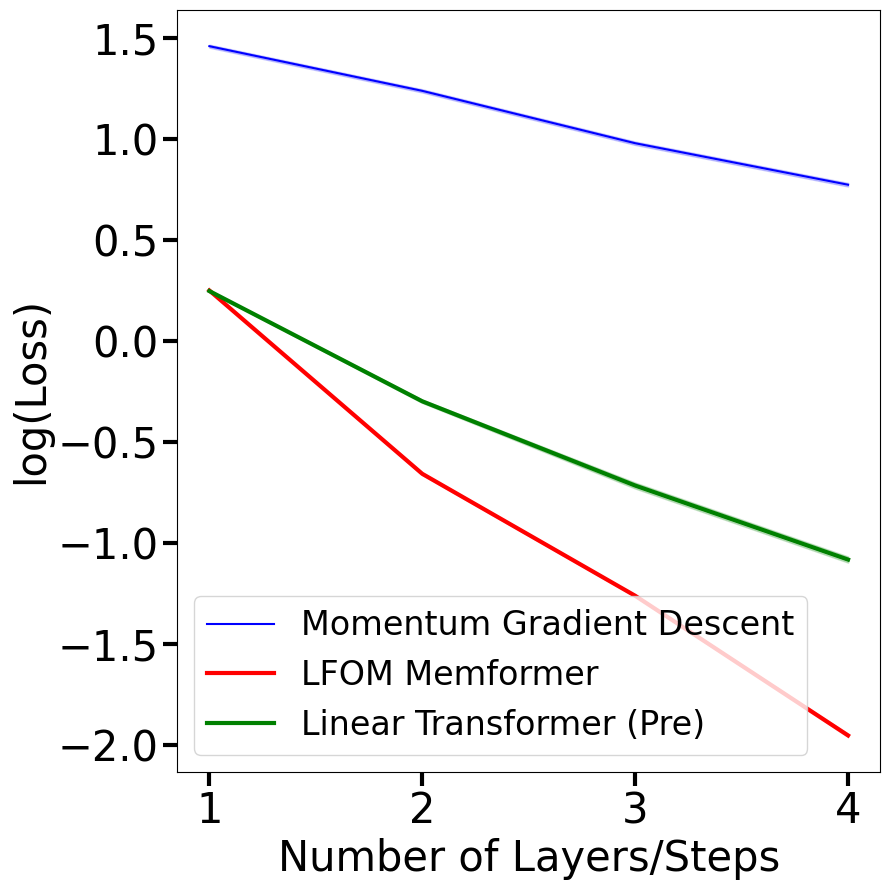

In [ ]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (9, 9))

losses = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict.keys()
for idx, key in enumerate(keys):
    losses[idx,:] = loss_dict[key]
losses_mean = torch.mean(losses, axis=0)
losses_std = torch.std(losses, axis=0)/10

losses_zero = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_zero.keys()
for idx, key in enumerate(keys):
    losses_zero[idx,:] = loss_dict_zero[key]
losses_mean_zero = torch.mean(losses_zero, axis=0)
losses_std_zero = torch.std(losses_zero, axis=0)/10

plt.plot(n_layers, gd_loss_mean, color='blue', label='Momentum Gradient Descent')
plt.fill_between(n_layers, gd_loss_mean - gd_loss_std/10, gd_loss_mean + gd_loss_std/10, color='blue', alpha=0.2)

ax.plot(n_layers, losses_mean, color = 'red', lw = 3, label='LFOM Memformer')
ax.fill_between(n_layers, losses_mean-losses_std, losses_mean+losses_std, color = 'red', alpha = 0.2)

ax.plot(n_layers, losses_mean_zero, color = 'green', lw = 3, label='Linear Transformer (Pre)')
ax.fill_between(n_layers, losses_mean_zero-losses_std_zero, losses_mean_zero+losses_std_zero, color = 'green', alpha = 0.2)

plt.ylabel('log(Loss)',fontsize=30)
plt.xlabel('Number of Layers/Steps',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
ax.legend(fontsize=24)
#ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)